<h1><center>Adaptive Computation & Machine Learning Project</center></h1>
<h2><center>Survival of Titanic Passengers</center></h2>
<h3><center>1657041</center></h3>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics import precision_score, recall_score, confusion_matrix, plot_confusion_matrix
from math import sqrt


import statsmodels.api as sm

np.set_printoptions(suppress=True, precision=7)

C:\Users\StevenCurtis\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\StevenCurtis\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


The dataset used in this project was taken from  [Kaggle](https://www.kaggle.com/c/titanic/data) and downloaded on 16 June 2020.

##### Training Dataset

In [2]:
dfTrain=pd.read_csv('train.csv',sep=',',index_col=0)#load training data
display(dfTrain.head(10))

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


##### Training Dataset Cleaning
Clean the dataset so that only necessary and helpful variables are used in training the models. There must be no null values in the training data and variables must be of the correct type.

In [3]:
dfTrain=dfTrain[['Survived','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']] #select only needed variables for this classification
dfTrain=dfTrain.dropna() #drop rows with null values. These can't be used to train the models as data is missing.

dict1 = {'male': 1, 'female': 2} #create sex dictionary to convert numeric values
dict2 = {'C': 1,'Q': 2, 'S': 3} #create embarked dictionary to convert numeric values

dfTrain.replace({"Sex": dict1},inplace=True) #convert numeric values
dfTrain.replace({"Embarked": dict2},inplace=True) #convert numeric values

dfTrain.info()
display(dfTrain.head(10))
print("Training observations:",dfTrain.shape[0]) #number of observation in training data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  712 non-null    int64  
 1   Pclass    712 non-null    int64  
 2   Sex       712 non-null    int64  
 3   Age       712 non-null    float64
 4   SibSp     712 non-null    int64  
 5   Parch     712 non-null    int64  
 6   Fare      712 non-null    float64
 7   Embarked  712 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 50.1 KB


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,3
2,1,1,2,38.0,1,0,71.2833,1
3,1,3,2,26.0,0,0,7.9250,3
4,1,1,2,35.0,1,0,53.1000,3
5,0,3,1,35.0,0,0,8.0500,3
7,0,1,1,54.0,0,0,51.8625,3
8,0,3,1,2.0,3,1,21.0750,3
9,1,3,2,27.0,0,2,11.1333,3
10,1,2,2,14.0,1,0,30.0708,1


Training observations: 712


##### Testing Dataset

In [4]:
dfTest=pd.read_csv('test.csv',sep=',',index_col=0)
display(dfTest.head(10))

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C


##### Training Dataset Cleaning
Clean the dataset so that the variables match those of the training dataset. There must be no null values in the testing data and variables must be of the correct type.

In [5]:
dfTest=dfTest[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']] #variables match those of the training dataset
dfTest=dfTest.dropna() #drop rows with null values. These can't be used to train the models as data is missing.

dfTest.replace({"Sex": dict1},inplace=True) #convert numeric values
dfTest.replace({"Embarked": dict2},inplace=True) #convert numeric values

dfTest.info()
display(dfTest.head(10))
print("Test observations:",dfTest.shape[0]) #number of observation in testing data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331 entries, 892 to 1307
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    331 non-null    int64  
 1   Sex       331 non-null    int64  
 2   Age       331 non-null    float64
 3   SibSp     331 non-null    int64  
 4   Parch     331 non-null    int64  
 5   Fare      331 non-null    float64
 6   Embarked  331 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 20.7 KB


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
892,3,1,34.5,0,0,7.8292,2
893,3,2,47.0,1,0,7.0000,3
894,2,1,62.0,0,0,9.6875,2
895,3,1,27.0,0,0,8.6625,3
896,3,2,22.0,1,1,12.2875,3
897,3,1,14.0,0,0,9.2250,3
898,3,2,30.0,0,0,7.6292,2
899,2,1,26.0,1,1,29.0000,3
900,3,2,18.0,0,0,7.2292,1


Test observations: 331


##### Normalization

In [6]:
def normParams(x):
    mu=np.mean(x, axis=0) #calculate mean
    std=np.std(x, axis=0) #calculate standard deviation
    return mu, std

def normData(x, mu, std):
    x=(x-mu)/(std+1e-8) #normalize the data
    return x

In [7]:
Xtrain = dfTrain[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']] #data used to train the model. i.e. drop survived from train
Ytrain = dfTrain['Survived'] #target data for training

mu, std = normParams(Xtrain) 
XtrainNorm = normData(Xtrain, mu, std) #normalize training data
testNorm = normData(dfTest, mu, std) #normalize testing data

display(XtrainNorm.head(10))
display(testNorm.head(10))

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
1,0.908600,-0.756137,-0.527669,0.522511,-0.506787,-0.516380,0.519588
2,-1.482983,1.322511,0.577094,0.522511,-0.506787,0.694046,-2.049487
3,0.908600,1.322511,-0.251478,-0.552714,-0.506787,-0.503620,0.519588
4,-1.482983,1.322511,0.369951,0.522511,-0.506787,0.350326,0.519588
5,0.908600,-0.756137,0.369951,-0.552714,-0.506787,-0.501257,0.519588
7,-1.482983,-0.756137,1.681856,-0.552714,-0.506787,0.326933,0.519588
8,0.908600,-0.756137,-1.908622,2.672960,0.664747,-0.255045,0.519588
9,0.908600,1.322511,-0.182430,-0.552714,1.836281,-0.442974,0.519588
10,-0.287191,1.322511,-1.080050,0.522511,-0.506787,-0.084997,-2.049487


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
892,0.908600,-0.756137,0.335427,-0.552714,-0.506787,-0.505431,-0.764949
893,0.908600,1.322511,1.198523,0.522511,-0.506787,-0.521106,0.519588
894,-0.287191,-0.756137,2.234238,-0.552714,-0.506787,-0.470304,-0.764949
895,0.908600,-0.756137,-0.182430,-0.552714,-0.506787,-0.489679,0.519588
896,0.908600,1.322511,-0.527669,0.522511,0.664747,-0.421156,0.519588
897,0.908600,-0.756137,-1.080050,-0.552714,-0.506787,-0.479046,0.519588
898,0.908600,1.322511,0.024713,-0.552714,-0.506787,-0.509212,-0.764949
899,-0.287191,-0.756137,-0.251478,0.522511,0.664747,-0.105238,0.519588
900,0.908600,1.322511,-0.803859,-0.552714,-0.506787,-0.516773,-2.049487


### Logistic Regression

In [8]:
survTrain=0
deadTrain=0
for j in Ytrain:
    if j==1:
        survTrain=survTrain+1 #find how many people survived from training data
    else:
        deadTrain=deadTrain+1 #find how many people died from training data

print("Out of the 712 people used to train the Logistic Regression model, survived:",survTrain)
print("Out of the 712 people used to train the Logistic Regression model, dead:",deadTrain)
print("Survived percentage:",str(round((survTrain/len(dfTrain))*100,2))+"%","\n") #survival percentage

logReg = linear_model.LogisticRegression() #create logistic regression model
logReg.fit(XtrainNorm, Ytrain) #learn the training data to target value

predictLogReg=np.round(logReg.predict(testNorm)) #predict if survived or not from test data

survTest=0
deadTest=0
for i in predictLogReg:
    if i==1:
        survTest=survTest+1 #find how many people survived from testing data
    else:
        deadTest=deadTest+1 #find how many people died from testing data
        
print("Out of the 331 people used to test the Logistic Regression model, survived:",survTest)
print("Out of the 331 people used to test the Logistic Regression model, dead:",deadTest)
print("Survived percentage:",str(round((survTest/len(dfTest))*100,2))+"%") #survival percentage

logRegAccuracy = round(logReg.score(XtrainNorm, Ytrain) * 100, 2)#find accuracy of model from training data as no label for testing data was given
print("\nLogistic Regression Accuracy:",str(logRegAccuracy)+"%")

logRegCrossValid = cross_val_score(logReg, XtrainNorm, Ytrain, cv=8, scoring = "accuracy") #accuracy using cross validation.
logRegCrossValid=round(logRegCrossValid.mean()*100,2) #find the average of each accuracy from each fold of training data
print("\nLogistic Regression accuracy using cross validation", str(logRegCrossValid)+"%")


logRegCrossValPredict = cross_val_predict(logReg, XtrainNorm, Ytrain, cv=8)#find the cross validation prediction
confMat=confusion_matrix(Ytrain, logRegCrossValPredict) #confusion matrix for cross validation prediction

print("\nFrom the",survTrain,"people that survived, there were",confMat[1][1],"true positives and",confMat[1][0],"false negative.")# confusion matrix values for survived
print("From the",deadTrain,"people that did not survive, there were",confMat[0][0],"true negatives and",confMat[0][1],"false positive.")# confusion matrix values for not survived

logRegPrecision=round(precision_score(Ytrain, logRegCrossValPredict)*100,2)#precison of Logistic Regression
logRegRecall=round(recall_score(Ytrain, logRegCrossValPredict)*100,2)#recall of Logistic Regression
logRegFscore=round(2*((logRegRecall*logRegPrecision)/(logRegRecall+logRegPrecision)),2)#F score of Logistic Regression

print("\nLogistic Regression precision:", str(logRegPrecision)+"%")
print("Logistic Regression recall:",str(logRegRecall)+"%") 
print("Logistic Regression F-score:",str(logRegFscore)+"%") 

Out of the 712 people used to train the Logistic Regression model, survived: 288
Out of the 712 people used to train the Logistic Regression model, dead: 424
Survived percentage: 40.45% 

Out of the 331 people used to test the Logistic Regression model, survived: 135
Out of the 331 people used to test the Logistic Regression model, dead: 196
Survived percentage: 40.79%

Logistic Regression Accuracy: 80.2%

Logistic Regression accuracy using cross validation 79.35%

From the 288 people that survived, there were 202 true positives and 86 false negative.
From the 424 people that did not survive, there were 363 true negatives and 61 false positive.

Logistic Regression precision: 76.81%
Logistic Regression recall: 70.14%
Logistic Regression F-score: 73.32%


In [9]:
#show survived or not on test
dfTestLogReg=dfTest.copy()
predictLogReg=list(predictLogReg) #convert predictions to list

dfTestLogReg['Survived'] = predictLogReg #add survived column to test data with if they survived from not for logistic regression
dict3 = {0: "No", 1: "Yes"}
dfTestLogReg.replace({"Survived": dict3},inplace=True) #convert 1 to yes and 0 to no

display(dfTestLogReg.head(10))

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
PassengerId,,,,,,,,
892,3,1,34.5,0,0,7.8292,2,No
893,3,2,47.0,1,0,7.0000,3,No
894,2,1,62.0,0,0,9.6875,2,No
895,3,1,27.0,0,0,8.6625,3,No
896,3,2,22.0,1,1,12.2875,3,Yes
897,3,1,14.0,0,0,9.2250,3,No
898,3,2,30.0,0,0,7.6292,2,Yes
899,2,1,26.0,1,1,29.0000,3,No
900,3,2,18.0,0,0,7.2292,1,Yes


### Perceptron

In [10]:
percep= Perceptron(max_iter=20)#create perceptron model
percep.fit(XtrainNorm, Ytrain) #learn the training data to target value

predictPercep=np.round(percep.predict(testNorm)) #predict if survived or not from test data

survTestPercep=0
deadTestPercep=0
for i in predictPercep:
    if i==1:
        survTestPercep=survTestPercep+1 #find how many people survived from testing data
    else:
        deadTestPercep=deadTestPercep+1 #find how many people died from testing data
        
print("Out of the 331 people used to test the Perceptron model, survived:",survTestPercep)
print("Out of the 331 people used to test the Perceptron model, dead:",deadTestPercep)
print("Survived percentage:",str(round((survTestPercep/len(dfTest))*100,2))+"%") #survival percentage

percepAccuracy = round(percep.score(XtrainNorm, Ytrain) * 100, 2)#find accuracy of model from training data as no label for testing data was given
print("\nPerceptron Accuracy:",str(percepAccuracy)+"%")

percepCrossValid = cross_val_score(percep, XtrainNorm, Ytrain, cv=8, scoring = "accuracy") #accuracy using cross validation.
percepCrossValid=round(percepCrossValid.mean()*100,2) #find the average of each accuracy from each fold of training data
print("\nPerceptron accuracy using cross validation", str(percepCrossValid)+"%")


percepCrossValPredict = cross_val_predict(percep, XtrainNorm, Ytrain, cv=8)#find the cross validation prediction
confMatPercep=confusion_matrix(Ytrain, percepCrossValPredict) #confusion matrix for cross validation prediction

print("\nFrom the",survTrain,"people that survived, there were",confMatPercep[1][1],"true positives and",confMatPercep[1][0],"false negative.")# confusion matrix values for survived
print("From the",deadTrain,"people that did not survive, there were",confMatPercep[0][0],"true negatives and",confMatPercep[0][1],"false positive.")# confusion matrix values for not survived

percepPrecision=round(precision_score(Ytrain, percepCrossValPredict)*100,2)#precison of Perceptron
percepRecall=round(recall_score(Ytrain, percepCrossValPredict)*100,2)#recall of Perceptron
percepFscore=round(2*((percepRecall*percepPrecision)/(percepRecall+percepPrecision)),2)#F score of Perceptron

print("\nPerceptron precision:", str(percepPrecision)+"%")
print("Perceptron recall:",str(percepRecall)+"%") 
print("Perceptron F-score:",str(percepFscore)+"%") 

Out of the 331 people used to test the Perceptron model, survived: 142
Out of the 331 people used to test the Perceptron model, dead: 189
Survived percentage: 42.9%

Perceptron Accuracy: 72.05%

Perceptron accuracy using cross validation 70.79%

From the 288 people that survived, there were 213 true positives and 75 false negative.
From the 424 people that did not survive, there were 291 true negatives and 133 false positive.

Perceptron precision: 61.56%
Perceptron recall: 73.96%
Perceptron F-score: 67.19%


In [11]:
#show survived or not on test
dfTestPercep=dfTest.copy()
predictPercep=list(predictPercep) #convert predictions to list

dfTestPercep['Survived'] = predictPercep #add survived column to test data with if they survived from not for perceptron
dfTestPercep.replace({"Survived": dict3},inplace=True) #convert 1 to yes and 0 to no

display(dfTestPercep.head(10))

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
PassengerId,,,,,,,,
892,3,1,34.5,0,0,7.8292,2,No
893,3,2,47.0,1,0,7.0000,3,No
894,2,1,62.0,0,0,9.6875,2,No
895,3,1,27.0,0,0,8.6625,3,No
896,3,2,22.0,1,1,12.2875,3,No
897,3,1,14.0,0,0,9.2250,3,No
898,3,2,30.0,0,0,7.6292,2,Yes
899,2,1,26.0,1,1,29.0000,3,No
900,3,2,18.0,0,0,7.2292,1,Yes


### K Nearest Neighbour

##### Elbow method to choose best k

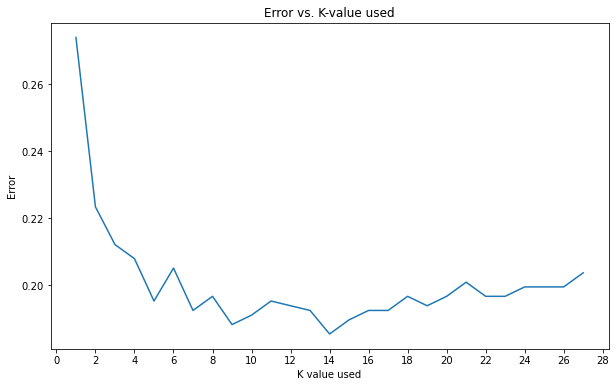

In [12]:
arr=[]
for i in range(1,28):
    model= KNeighborsClassifier(n_neighbors = i)#create K Nearest Neighbour model
    model.fit(XtrainNorm, Ytrain) #learn the training data to target value
    modelValid = cross_val_score(model, XtrainNorm, Ytrain, cv=8, scoring = "accuracy") #accuracy using cross validation.
    modelValid=modelValid.mean() #find the mean of these values
    arr.append(1-modelValid) #add it to the array for plotting

#plot the error
plt.figure(figsize=(10,6))
plt.plot(range(1,28),arr)
plt.locator_params(axis='x', nbins=20)
plt.title("Error vs. K-value used")
plt.xlabel("K value used")
plt.ylabel("Error")
plt.show()

##### KNN with K=9 to avoid tie

In [13]:
knn = KNeighborsClassifier(n_neighbors = 9) #create K Nearest Neighbour model using  euclidean distance
knn.fit(XtrainNorm, Ytrain) #learn the training data to target value

predictKnn=np.round(knn.predict(testNorm)) #predict if survived or not from test data

survTestKnn=0
deadTestKnn=0
for i in predictKnn:
    if i==1:
        survTestKnn=survTestKnn+1 #find how many people survived from testing data
    else:
        deadTestKnn=deadTestKnn+1 #find how many people died from testing data
        
print("Out of the 331 people used to test the K Nearest Neighbour model, survived:",survTestKnn)
print("Out of the 331 people used to test the K Nearest Neighbour model, dead:",deadTestKnn)
print("Survived percentage:",str(round((survTestKnn/len(dfTest))*100,2))+"%") #survival percentage

knnAccuracy = round(knn.score(XtrainNorm, Ytrain) * 100, 2)#find accuracy of model from training data as no label for testing data was given
print("\nK Nearest Neighbour Accuracy:",str(knnAccuracy)+"%")

knnCrossValid = cross_val_score(knn, XtrainNorm, Ytrain, cv=8, scoring = "accuracy") #accuracy using cross validation.
knnCrossValid=round(knnCrossValid.mean()*100,2) #find the average of each accuracy from each fold of training data
print("\nK Nearest Neighbour accuracy using cross validation", str(knnCrossValid)+"%")


knnCrossValPredict = cross_val_predict(knn, XtrainNorm, Ytrain, cv=8)#find the cross validation prediction
confMatKnn=confusion_matrix(Ytrain, knnCrossValPredict) #confusion matrix for cross validation prediction

print("\nFrom the",survTrain,"people that survived, there were",confMatKnn[1][1],"true positives and",confMatKnn[1][0],"false negative.")# confusion matrix values for survived
print("From the",deadTrain,"people that did not survive, there were",confMatKnn[0][0],"true negatives and",confMatKnn[0][1],"false positive.")# confusion matrix values for not survived

knnPrecision=round(precision_score(Ytrain, knnCrossValPredict)*100,2)#precison of K Nearest Neighbour
knnRecall=round(recall_score(Ytrain, knnCrossValPredict)*100,2)#recall of K Nearest Neighbour
knnFscore=round(2*((knnRecall*knnPrecision)/(knnRecall+knnPrecision)),2)#F score of K Nearest Neighbour

print("\nK Nearest Neighbour precision:", str(knnPrecision)+"%")
print("K Nearest Neighbour recall:",str(knnRecall)+"%") 
print("K Nearest Neighbour F-score:",str(knnFscore)+"%") 

Out of the 331 people used to test the K Nearest Neighbour model, survived: 138
Out of the 331 people used to test the K Nearest Neighbour model, dead: 193
Survived percentage: 41.69%

K Nearest Neighbour Accuracy: 84.41%

K Nearest Neighbour accuracy using cross validation 81.18%

From the 288 people that survived, there were 206 true positives and 82 false negative.
From the 424 people that did not survive, there were 372 true negatives and 52 false positive.

K Nearest Neighbour precision: 79.84%
K Nearest Neighbour recall: 71.53%
K Nearest Neighbour F-score: 75.46%


In [14]:
#show survived or not on test
dfTestKnn=dfTest.copy()
predictKnn=list(predictKnn) #convert predictions to list

dfTestKnn['Survived'] = predictKnn #add survived column to test data with if they survived from not for KNN
dfTestKnn.replace({"Survived": dict3},inplace=True) #convert 1 to yes and 0 to no

display(dfTestKnn.head(10))

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
PassengerId,,,,,,,,
892,3,1,34.5,0,0,7.8292,2,No
893,3,2,47.0,1,0,7.0000,3,No
894,2,1,62.0,0,0,9.6875,2,No
895,3,1,27.0,0,0,8.6625,3,No
896,3,2,22.0,1,1,12.2875,3,No
897,3,1,14.0,0,0,9.2250,3,No
898,3,2,30.0,0,0,7.6292,2,Yes
899,2,1,26.0,1,1,29.0000,3,No
900,3,2,18.0,0,0,7.2292,1,Yes


### KNN has the best accuracy so we implement our own method for KNN

In [15]:
def euclideanDist(row, row1): #calculate the euclidean distance between 2 rows
    dist = 0.0
    for i in range(len(row)-1):#as to not include the target
        dist =dist+ (row[i] - row1[i])**2  #find distance total
    return sqrt(dist) #calc euclidean distance

def neighbours(trainingData, inputRow, neighbourNum):
    distances = list()
    for i in range(len(trainingData)): #loop through all records in training data
        trainingDataRow=np.array(trainingData.iloc[i])
        dist = euclideanDist(inputRow, trainingDataRow) #calculate the euclidean distance between input row and all rows in training data
        dist=np.round(dist,2) #round distance to 2 decimal places
        distances.append((trainingDataRow, dist)) #add distances to list
    distances.sort(key=lambda tup: tup[1]) #sort the list, smallest to biggest
    neigh = list()
    for i in range(neighbourNum):
        neigh.append(distances[i][0]) #add K smallest distances from distance list to new output list containing the KNN records
    return neigh

# Make a classification prediction with neighbors with neigbours =9
def predictionOwnKnn(trainData, testRow, neighbourNum):
    n = neighbours(trainData, testRow, neighbourNum) #9 nearest neighbours
    outputKnn = [row[-1] for row in n] #only label bredictions from 9 neighbours from own Knn method
    p = max(set(outputKnn),key=outputKnn.count)#select the most common label from 9 nearest neighbours i.e. the one that appears the most
    return p

In [16]:
trainOwnNorm=XtrainNorm.copy() #copy normalized traindata to new dataframe
trainOwnNorm.insert(7,"Survived",list(dfTrain["Survived"])) #add the traget labels to normalized training data

testOwnNorm=testNorm.copy() #copy normalized test data to new dataframe

predictOwnKnn = list() #will store predictions from own KNN method
for i in range(len(testNorm)): #loop through all records in training data
    testRow=np.array(testNorm.iloc[i]) #current row for prediction
    output = predictionOwnKnn(trainOwnNorm, testRow, 9) #predict test row 
    predictOwnKnn.append(int(output)) #add it to prediction list
    
survTestOwnKnn=0
deadTestOwnKnn=0
for i in predictOwnKnn:
    if i==1:
        survTestOwnKnn=survTestOwnKnn+1 #find how many people survived from testing data
    else:
        deadTestOwnKnn=deadTestOwnKnn+1 #find how many people died from testing data
        
print("Out of the 331 people used to test own K Nearest Neighbour model, survived:",survTestOwnKnn)
print("Out of the 331 people used to test own K Nearest Neighbour model, dead:",deadTestOwnKnn)
print("Survived percentage:",str(round((survTestOwnKnn/len(dfTest))*100,2))+"%") #survival percentage


#find accuracy of model from training data as no label for testing data was given
predictOwnKnnAcc = list() #will store predictions from own KNN method
for i in range(len(trainOwnNorm)): #loop through all records in training data
    trainRow=np.array(trainOwnNorm.iloc[i]) #current row for prediction
    outputAcc = predictionOwnKnn(trainOwnNorm, trainRow, 9) #predict test row 
    predictOwnKnnAcc.append(int(outputAcc)) #add it to prediction list

count=0
YtrainOwn=np.array(Ytrain)
for i in range(len(YtrainOwn)):
    if YtrainOwn[i] == predictOwnKnnAcc[i]: #if the training label = prediction lable, correct number increases
        count =count+1
knnAccuracyOwn=round(count/float(len(YtrainOwn))*100,2) #total correct labels /total lables is accuracy

print("\nOwn K Nearest Neighbour Accuracy:",str(knnAccuracyOwn)+"%")


#cross validation
acc=list()
crossValPredict=list()
folds=KFold(n_splits=8)
for trainInd, testInd in folds.split(trainOwnNorm): #split the data into 8 sections for cross validation
    trainCross=trainOwnNorm.iloc[trainInd] 
    tesCross=trainOwnNorm.iloc[testInd]
    
    predictOwnKnnAccCross = list() #will store predictions from own KNN method

    for i in range(len(tesCross)): #loop through all records in training data
        testRow=np.array(tesCross.iloc[i]) #current row for prediction
        outputAcc = predictionOwnKnn(trainCross, testRow, 9) #predict test row 
        predictOwnKnnAccCross.append(int(outputAcc)) #add it to prediction list
        crossValPredict.append(int(outputAcc)) #add it to total cross val predict

    count=0
    YtrainOwnCross=np.array(tesCross.iloc[:,-1])
    for i in range(len(YtrainOwnCross)):
        if YtrainOwnCross[i] == predictOwnKnnAccCross[i]: #if the training label = prediction lable, correct number increases
            count =count+1
    knnAccuracyOwnCross=round(count/float(len(YtrainOwnCross))*100,2) #total correct labels /total lables is accuracy
    acc.append(knnAccuracyOwnCross) #add accuracy to list to find mean of accuracies
crossValAcc=round(np.mean(acc),2) #find mean of accuracies

print("\nOwn K Nearest Neighbour Accuracy after cross validation:",str(crossValAcc)+"%")


confMatKnnOwn=np.zeros([2,2]) #confusion matrix

truePos=0
falseNeg=0
trueNeg=0
falsePos=0

for i in range(len(YtrainOwn)):
    if YtrainOwn[i] == 1 and crossValPredict[i]==1: #true positive
        truePos=truePos+1
    elif YtrainOwn[i] == 1 and crossValPredict[i]==0: #false negative
        falseNeg=falseNeg+1
    elif YtrainOwn[i] == 0 and crossValPredict[i]==0: #true negative
        trueNeg=trueNeg+1
    elif YtrainOwn[i] == 0 and crossValPredict[i]==1: #false positive
        falsePos=falsePos+1

confMatKnnOwn[1][1]=truePos #add to confusion matrix to create it
confMatKnnOwn[1][0]=falseNeg #add to confusion matrix to create it
confMatKnnOwn[0][0]=trueNeg #add to confusion matrix to create it
confMatKnnOwn[0][1]=falsePos #add to confusion matrix to create it
print("\nFrom the",survTrain,"people that survived, there were",int(confMatKnnOwn[1][1]),"true positives and",int(confMatKnnOwn[1][0]),"false negative.")# confusion matrix values for survived
print("From the",deadTrain,"people that did not survive, there were",int(confMatKnnOwn[0][0]),"true negatives and",int(confMatKnnOwn[0][1]),"false positive.")# confusion matrix values for not survived

knnPrecisionOwn=round((truePos/(truePos+falsePos))*100,2)#precison of own K Nearest Neighbour
knnRecallOwn=round((truePos/(truePos+falseNeg))*100,2)#recall of own K Nearest Neighbour
knnFscoreOwn=round(2*((knnRecallOwn*knnPrecisionOwn)/(knnRecallOwn+knnPrecisionOwn)),2)#F score of own K Nearest Neighbour

print("\nOwn K Nearest Neighbour precision:", str(knnPrecisionOwn)+"%")
print("Own K Nearest Neighbour recall:",str(knnRecallOwn)+"%") 
print("Own K Nearest Neighbour F-score:",str(knnFscoreOwn)+"%") 

Out of the 331 people used to test own K Nearest Neighbour model, survived: 133
Out of the 331 people used to test own K Nearest Neighbour model, dead: 198
Survived percentage: 40.18%

Own K Nearest Neighbour Accuracy: 84.69%

Own K Nearest Neighbour Accuracy after cross validation: 81.46%

From the 288 people that survived, there were 209 true positives and 79 false negative.
From the 424 people that did not survive, there were 371 true negatives and 53 false positive.

Own K Nearest Neighbour precision: 79.77%
Own K Nearest Neighbour recall: 72.57%
Own K Nearest Neighbour F-score: 76.0%


In [17]:
#show survived or not on test
dfTestKnnOwn=dfTest.copy()
predictOwnKnn=list(predictOwnKnn) #convert predictions to list

dfTestKnnOwn['Survived'] = predictOwnKnn #add survived column to test data with if they survived from not for KNN
dfTestKnnOwn.replace({"Survived": dict3},inplace=True) #convert 1 to yes and 0 to no

display(dfTestKnnOwn.head(10))

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
PassengerId,,,,,,,,
892,3,1,34.5,0,0,7.8292,2,No
893,3,2,47.0,1,0,7.0000,3,No
894,2,1,62.0,0,0,9.6875,2,No
895,3,1,27.0,0,0,8.6625,3,No
896,3,2,22.0,1,1,12.2875,3,No
897,3,1,14.0,0,0,9.2250,3,No
898,3,2,30.0,0,0,7.6292,2,Yes
899,2,1,26.0,1,1,29.0000,3,No
900,3,2,18.0,0,0,7.2292,1,Yes


##### Combined dataset using most accurate model (Own KNN)

In [18]:
trainDf=dfTrain.copy()
trainDf.replace({"Survived": dict3},inplace=True)#convert numeric survived or not to yes or no

combinedDf=trainDf.append(dfTestKnnOwn) #add the knnTest dataset with survived predictions to the ned of training dataset
display(combinedDf)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,No,3,1,22.0,1,0,7.2500,3
2,Yes,1,2,38.0,1,0,71.2833,1
3,Yes,3,2,26.0,0,0,7.9250,3
4,Yes,1,2,35.0,1,0,53.1000,3
5,No,3,1,35.0,0,0,8.0500,3
...,...,...,...,...,...,...,...,...
1301,Yes,3,2,3.0,1,1,13.7750,3
1303,Yes,1,2,37.0,1,0,90.0000,2
1304,No,3,2,28.0,0,0,7.7750,3


##### Gender Percent Survived

In [19]:
maleDf=combinedDf.loc[combinedDf["Sex"]==1] #dataframe of males only
maleSum=maleDf.shape[0] #how many males

femaleDf=combinedDf.loc[combinedDf["Sex"]==2] #dataframe of females only
femaleSum=femaleDf.shape[0] #how many females

maleSurv=maleDf.loc[maleDf["Survived"]=="Yes"].shape[0] #how many males survived
print("Male survived percent:",str(round((maleSurv/maleSum)*100,2))+"%") #percentage of males that survived from total males

femaleSurv=femaleDf.loc[femaleDf["Survived"]=="Yes"].shape[0] #how many females survived
print("Female survived percent:",str(round((femaleSurv/femaleSum)*100,2))+"%") #percentage of females that survived from total females

Male survived percent: 18.11%
Female survived percent: 78.24%


##### Average Fee paid for ticket 

In [20]:
fareDf=combinedDf[["Survived","Fare"]] #dataframe of survived and the fare they paid only

survFareDf=fareDf.loc[fareDf["Survived"]=="Yes"] #fare that people who survived paid
meanFareSurv=survFareDf["Fare"].sum()/survFareDf.shape[0] #average price paid of people who survived
print("Mean price paid for ticket survived:",(round(meanFareSurv,2)))

deadFareDf=fareDf.loc[fareDf["Survived"]=="No"] #fare that people who did not survive paid
meanFareDead=deadFareDf["Fare"].sum()/deadFareDf.shape[0] #average price paid of people who did not survive
print("Mean price paid for ticket died:",(round(meanFareDead,2)))

Mean price paid for ticket survived: 55.8
Mean price paid for ticket died: 23.61


##### Average age survived

In [21]:
ageDf=combinedDf[["Survived","Age"]] #dataframe of survived and their age only
print("Mean age :",(int(round(ageDf["Age"].sum()/ageDf.shape[0]))))

survAgeDf=ageDf.loc[ageDf["Survived"]=="Yes"] #age of people who survived
meanAgeSurv=survAgeDf["Age"].sum()/survAgeDf.shape[0] #average age of people who survived
print("Mean age survived:",(int(round(meanAgeSurv))))

deadAgeDf=ageDf.loc[ageDf["Survived"]=="No"] #age of people who did not survive
meanAgeDead=deadAgeDf["Age"].sum()/deadAgeDf.shape[0] #average age of people who did not survive
print("Mean age died:",(int(round(meanAgeDead))))

Mean age : 30
Mean age survived: 29
Mean age died: 31


##### Ticket class that survived the most

In [22]:
classDf=combinedDf[["Survived","Pclass"]] #dataframe of survived and their cabin class

oneClassDf=classDf.loc[classDf["Pclass"]==1] #where the cabin class is 1st class
survOneClass=oneClassDf.loc[oneClassDf["Survived"]=="Yes"].shape[0] #number of people who survived from 1st class
print("Ticket class 1 that survived",str(round((survOneClass/oneClassDf.shape[0])*100,2))+"%") #percentage of people who survived in 1st class from total people in 1st class

twoClassDf=classDf.loc[classDf["Pclass"]==2] #where the cabin class is 2nd class
survTwoClass=twoClassDf.loc[twoClassDf["Survived"]=="Yes"].shape[0] #number of people who survived from 2nd class
print("Ticket class 2 that survived",str(round((survTwoClass/twoClassDf.shape[0])*100,2))+"%") #percentage of people who survived in 2nd class from total people in 2nd class

threeClassDf=classDf.loc[classDf["Pclass"]==3] #where the cabin class is 3rd class
survThreeClass=threeClassDf.loc[threeClassDf["Survived"]=="Yes"].shape[0] #number of people who survived from 3rd class
print("Ticket class 3 that survived",str(round((survThreeClass/threeClassDf.shape[0])*100,2))+"%") #percentage of people who survived in 3rd class from total people in 3rd class

Ticket class 1 that survived 66.31%
Ticket class 2 that survived 43.68%
Ticket class 3 that survived 24.0%
